In [1]:

import pandas as pd
import pickle
%pylab inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_validate,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score


import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder, PolynomialFeatures,RobustScaler

import scipy.stats as stats
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
horror_df=pd.read_pickle('horror_df.pkl')
horror_df

,Movie,Year,Runtime_min,Genres,IMDB_Score,IMDB_Votes,Metascore,Director,Star,Budget,...,Novel_Adaptation,Male_Score,Male_Total_Votes,Female_Score,Female_Total_Votes,Link_stub,Female_Protagonist,Creature_Feature,Cult_Classic,Murder
0,Psycho,1960,109,"[Horror, Mystery, Thriller ]",8.5,602815,97,Alfred Hitchcock,"[Anthony Perkins, Janet Leigh, Vera Miles]",806947,...,1,8.5,353389,8.4,88145,/title/tt0054215/,0,0,1,1
1,The Shining,1980,146,"[Drama, Horror ]",8.4,896027,66,Stanley Kubrick,"[Jack Nicholson, Shelley Duvall, Danny Lloyd]",19000000,...,1,8.4,530475,8.3,124287,/title/tt0081505/,0,0,1,1
2,Alien,1979,117,"[Horror, Sci-Fi ]",8.4,786083,89,Ridley Scott,"[Sigourney Weaver, Tom Skerritt, John Hurt]",11000000,...,0,8.5,507612,8.2,73461,/title/tt0078748/,1,1,1,1
3,The Thing,1982,109,"[Horror, Mystery, Sci-Fi ]",8.1,370424,57,John Carpenter,"[Kurt Russell, Wilford Brimley, Keith David]",15000000,...,0,8.2,252886,7.7,28831,/title/tt0084787/,0,1,1,1
4,What Ever Happened to Baby Jane?,1962,134,"[Drama, Horror, Thriller ]",8.1,49967,75,Robert Aldrich,"[Bette Davis, Joan Crawford, Victor Buono]",980000,...,1,8.0,28768,8.3,10292,/title/tt0056687/,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,Slender Man,2018,93,"[Horror, Mystery, Thriller ]",3.2,28703,30,Sylvain White,"[Joey King, Julia Goldani Telles, Jaz Sinclair]",10000000,...,0,3.2,14850,3.4,4180,/title/tt5690360/,0,1,0,1
680,Jaws: The Revenge,1987,89,"[Adventure, Horror, Thriller ]",3.0,41154,15,Joseph Sargent,"[Lorraine Gary, Lance Guest, Mario Van Peebles]",23000000,...,0,2.9,27697,3.6,3417,/title/tt0093300/,0,0,0,0
681,BloodRayne,2005,95,"[Action, Fantasy, Horror ]",2.9,34131,18,Uwe Boll,"[Kristanna Loken, Ben Kingsley, Michelle Rodri...",25000000,...,0,2.9,25173,3.1,3255,/title/tt0383222/,1,0,1,1
682,Alone in the Dark,2005,96,"[Action, Horror, Sci-Fi ]",2.4,41668,9,Uwe Boll,"[Christian Slater, Tara Reid, Stephen Dorff]",20000000,...,0,2.3,30832,2.6,3395,/title/tt0369226/,0,1,1,1


In [3]:
#removing outlier residuals

horror_df=horror_df.drop([681])
horror_df=horror_df.drop([682])
horror_df=horror_df.drop([683])
horror_df=horror_df.drop([668])

In [4]:
#sns.pairplot(horror_df,plot_kws=dict(alpha=.2,edgecolor='none'));

In [5]:
#horror_df.corr()
#sns.heatmap(horror_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [6]:
X=horror_df.loc[:,['Year','Runtime_min','Novel_Adaptation',
                  'Female_Protagonist','Creature_Feature',
                  'Cult_Classic','Murder','Budget']]
y=horror_df['Male_Score']

In [7]:
mlb = MultiLabelBinarizer()
dum = mlb.fit_transform(horror_df.Genres)
Genre_dum=pd.DataFrame(dum,horror_df.index,mlb.classes_)
combined_X=pd.concat([Genre_dum,X],axis=1)
X=combined_X
y=horror_df['Male_Score']

In [8]:
dir_counts=horror_df.Director.value_counts()
other_d = list(dir_counts[dir_counts <= 3].index)
X['Director']=horror_df['Director'].replace(other_d,'Other')
X=pd.get_dummies(X,drop_first=True)
y=horror_df['Male_Score']

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=41)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=41)

In [10]:
model=sm.OLS(y_train,sm.add_constant(X_train))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Male_Score   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     4.337
Date:                Sun, 24 Jan 2021   Prob (F-statistic):           1.97e-18
Time:                        19:42:40   Log-Likelihood:                -445.85
No. Observations:                 408   AIC:                             1014.
Df Residuals:                     347   BIC:                             1258.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           45.1221      5.503      8.199      0.000      34.298      55.946
 Adventure                       0.1204      0.330      0.365      0.715      -0.529       0.770
 Comedy                          0.0165      0.357      0.046      0.963      -0.685       0.718
 Comedy                          5.0691      0.819      6.188      0.000       3.458       6.680
 Crime                           0.6720      0.420      1.599      0.111      -0.154       1.498
 Crime                           4.3967      0.692      6.351      0.000       3.035       5.758
 Drama                           0.1761      0.274      0.642      0.521      -0.363       0.716
 Drama                           4.4083      0.682      6.462      0.000       3.067       5.750
 Family                         -0.8964      0.614     -1.460      0.145      -2.104       0.311
 Family                          5.1798      0.793      6.528      0.000       3.619       6.740
 Fantasy                        -0.0050      0.212     -0.023      0.981      -0.422       0.412
 Fantasy                         4.2636      0.589      7.240      0.000       3.105       5.422
 History                        -0.6227      0.854     -0.729      0.466      -2.303       1.057
 Horror                          2.8695      0.431      6.658      0.000       2.022       3.717
 Horror                          4.2877      0.575      7.451      0.000       3.156       5.419
 Music                           1.4878      0.822      1.809      0.071      -0.130       3.105
 Musical                         0.6767      0.934      0.725      0.469      -1.160       2.513
 Musical                         1.8306      0.592      3.094      0.002       0.667       2.994
 Mystery                         0.0718      0.157      0.456      0.649      -0.238       0.381
 Mystery                         1.5105      0.275      5.501      0.000       0.970       2.051
 Romance                         0.7091      0.550      1.289      0.198      -0.373       1.791
 Sci-Fi                          0.5693      0.306      1.860      0.064      -0.033       1.171
 Sci-Fi                          1.5930      0.264      6.026      0.000       1.073       2.113
 Thriller                        1.5945      0.264      6.036      0.000       1.075       2.114
 Western                         2.0768      0.738      2.816      0.005       0.626       3.528
Action                           3.8165      0.508      7.519      0.000       2.818       4.815
Adventure                        3.3624      0.493      6.824      0.000       2.393       4.332
Animation                        4.3645      0.802      5.445      0.000       2.788       5.941
Biography                        3.4861      0.925      3.768      0.000    

In [11]:
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)
val_score=lr_model.score(X_val,y_val)
val_score

0.1834632394149993

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=41)

In [13]:
alpha_list=np.logspace(-10,10,100)
params_Ridge={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipe=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Ridge(),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipe.fit(X_train,y_train)
robust_pred=pipe.predict(X_test)

In [14]:
r2_score(y_test,robust_pred)

0.29237367404761694

In [25]:
#unsure if adjusted r2 is correct, using mean error metrics later in notebook for analysis 
SS_Residual = sum((y_test-robust_pred)**2)       
SS_Total = sum((y_test-np.mean(y_test))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adjusted_r_squared

-0.3267993611607183

In [15]:
ridge_coef=list(zip(X_train.columns, pipe.named_steps['search'].best_estimator_.coef_))
ridge_coef
filtered=[(coef,val) for coef,val in ridge_coef if val !=0]
sorted(filtered,key=lambda x: abs(x[1]))

[('Director_Tobe Hooper', 0.0028595340189407356),
 ('Director_Darren Lynn Bousman', -0.003604108220925132),
 (' Fantasy', -0.007391154706487136),
 ('Action', 0.013534603006636194),
 (' Sci-Fi            ', 0.015555836892241456),
 ('Director_Joe Dante', -0.020526628855625482),
 (' Musical', 0.020931494411862865),
 (' Western            ', 0.02647411687170544),
 ('Biography', 0.0272019959322102),
 ('Novel_Adaptation', 0.027769988792410567),
 ('Fantasy', -0.03237351392613348),
 ('Director_Greg McLean', -0.03386502771809407),
 (' Mystery', 0.03472661851326115),
 (' Fantasy            ', 0.0352749753652509),
 (' Horror            ', -0.037111809235124506),
 (' Horror', -0.039320417510719054),
 (' Adventure', 0.040270216870999825),
 ('Director_Alexandre Aja', 0.04106438039126123),
 ('Director_Eli Roth', -0.04390796771506902),
 ('Director_George A. Romero', -0.0468770610036901),
 (' Romance            ', -0.047660818111147384),
 (' Crime            ', -0.04779710726377338),
 ('Creature_Featur

In [16]:
params_Lasso={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipeL=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Lasso(),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipeL.fit(X_train,y_train)
robust_predL=pipeL.predict(X_test)

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.6481602631525, tolerance: 0.04130217011494253
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.239242252704173, tolerance: 0.03969518620689656
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.0491848465979, tolerance: 0.039628496551724145
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/pytho

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.648159957039, tolerance: 0.04130217011494253
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.239242548564448, tolerance: 0.03969518620689656
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.04918788198512, tolerance: 0.039628496551724145
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/pytho

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.87918960734099, tolerance: 1.630422
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.75313206674363, tolerance: 1.633736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.64817011625918, tolerance: 0.04130217011494253
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.87932033565737, tolerance: 1.630422
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.75326532154764, tolerance: 1.633736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.64821361639618, tolerance: 0.04130217011494253
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.61960354836768, tolerance: 1.6542400000000002
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.87984832666535, tolerance: 1.630422
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.7538030919549, tolerance: 1.633736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/s

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112.40336414048615, tolerance: 1.6270440000000002
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.59269558423414, tolerance: 1.639718
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.62170374017262, tolerance: 1.6542400000000002
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.35562584982961, tolerance: 0.03936254252873564
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.19975232499226, tolerance: 0.04197834862385321
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112.41206969557415, tolerance: 1.6270440000000002
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/pyt

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.78255957972095, tolerance: 1.633736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.65775200479808, tolerance: 0.04130217011494253
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.24243771108658, tolerance: 0.03969518620689656
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.70449742473964, tolerance: 1.639718
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.73324300213478, tolerance: 1.6542400000000002
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.99489592726758, tolerance: 1.630422
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.25148122681189, tolerance: 0.04197834862385321
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112.8576358457576, tolerance: 1.6270440000000002
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.03688601494446, tolerance: 1.639718
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.2192083811445, tolerance: 1.6542400000000002
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.03037001075518, tolerance: 1.630422
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.4112513033931, tolerance: 1.633736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sk

In [17]:
r2_score(y_test,robust_predL)

0.2671548853573986

In [32]:
SS_Residual = sum((y_test-robust_predL)**2)       
SS_Total = sum((y_test-np.mean(y_test))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adjusted_r_squared

-0.3740845899548775

In [18]:
lasso_coef=list(zip(X_train.columns, pipeL.named_steps['search'].best_estimator_.coef_))
lasso_coef
filteredL=[(coef,val) for coef,val in lasso_coef if val !=0]
sorted(filteredL,key=lambda x: abs(x[1]))

[(' Fantasy            ', 0.01569846187453393),
 ('Director_William Brent Bell', -0.01860463096018306),
 ('Horror            ', -0.021018885139207598),
 (' Horror            ', -0.025319698035564702),
 ('Comedy', 0.032965238568822476),
 ('Creature_Feature', 0.03479144711997683),
 ('Director_Tim Burton', 0.04005217468229826),
 (' Thriller            ', -0.08587709883742528),
 (' Drama', 0.10407082360546238),
 ('Budget', -0.10984475844906878),
 ('Horror', -0.10992794221291984),
 (' Mystery            ', -0.11100917348962831),
 (' Comedy', 0.12055210399937227),
 ('Murder', 0.1272024015258481),
 ('Female_Protagonist', 0.1432948832838335),
 ('Cult_Classic', 0.15128197996003231),
 ('Director_Rob Zombie', -0.16189903697362962),
 ('Director_Sam Raimi', 0.16278836623345674),
 ('Drama', 0.1703460939648359),
 (' Sci-Fi', 0.172848152759637),
 ('Director_Other', -0.22639388454113482),
 (' Crime', 0.29932566976450015),
 ('Runtime_min', 0.35654898842831123),
 ('Adventure', -0.42001039778231586),
 ('Y

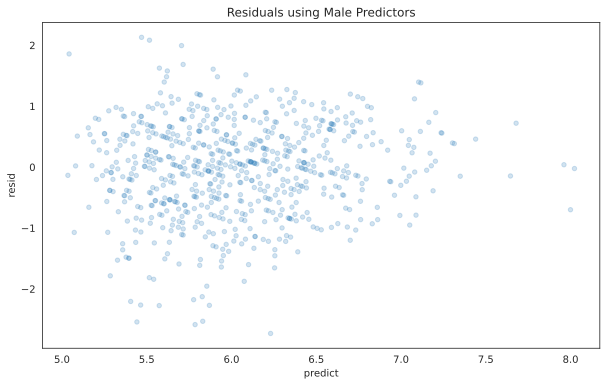

In [19]:
horror_df['predict']=pipe.predict(X)
horror_df['resid']=y-horror_df.predict
with sns.axes_style('white'):
    plot=horror_df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))
plt.title('Residuals using Male Predictors')    
plt.savefig('m_pred_residual_scatter.svg',format='svg')

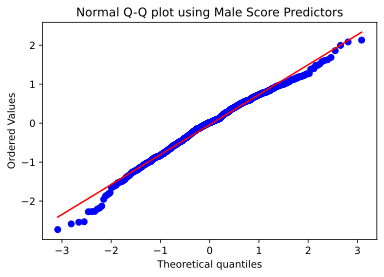

In [20]:
stats.probplot(horror_df['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot using Male Score Predictors")
plt.savefig('Male_pred_qq.svg',format='svg')
plt.show()

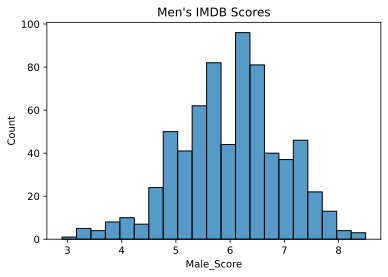

In [21]:
sns.histplot(horror_df.Male_Score)
plt.title("Men's IMDB Scores");
plt.savefig('Male_Score_hist.svg',format='svg')

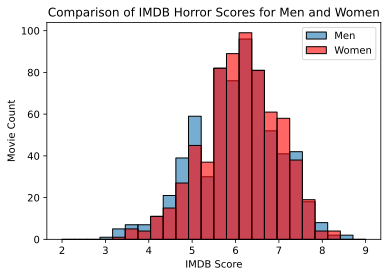

In [22]:
bins=np.linspace(2,9,25)
sns.histplot(horror_df.Male_Score, alpha=0.6, label='Men', bins=bins)
sns.histplot(horror_df.Female_Score,color='red', alpha=0.6,label='Women', bins=bins)
plt.xlabel('IMDB Score')
plt.ylabel('Movie Count')
plt.title('Comparison of IMDB Horror Scores for Men and Women')
plt.legend();
#sligtly left skewed
plt.savefig('Both_Genders_Score_hist.svg',format='svg')

In [23]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, robust_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, robust_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, robust_pred)))

Mean Absolute Error: 0.5880005069853524
Mean Squared Error: 0.5491047915521127
Root Mean Squared Error: 0.7410160535049917


In [24]:
from yellowbrick.regressor import PredictionError
visualizer=PredictionError(pipe)
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
plt.savefig('Male_Pred_Error.svg',format='svg')
visualizer.show()

ModuleNotFoundError: No module named 'yellowbrick'

In [ ]:
#plt.scatter(X_train['Runtime_min'],y_train, color='red')
plt.scatter(X_test['Runtime_min'],y_test, color='blue', alpha=0.6, label="Actual") #actual
plt.scatter(X_test['Runtime_min'],robust_pred, color="black", alpha=0.6, label="Predicted") #predicted
plt.title('Actual vs Predicted Test Values')
plt.ylabel("Mens's IMDB Score")
plt.xlabel("Runtime in minutes")
plt.legend(); 
plt.savefig('men_runtime_predicted_actual_scatter.svg',format='svg')

In [ ]:
horror_df['Female_Total_Votes'].min(),horror_df['Female_Total_Votes'].max()

In [ ]:
horror_df['Male_Total_Votes'].min(),horror_df['Male_Total_Votes'].max()

In [ ]:
Total_female_votes=horror_df['Female_Total_Votes'].sum()
Total_male_votes=horror_df['Male_Total_Votes'].sum()

In [ ]:
Calc_total=Total_female_votes+Total_male_votes
Calc_total

In [ ]:
Calc_Percent_f=(Total_female_votes/Calc_total)*100
Calc_Percent_f

In [ ]:
Calc_Percent_m=(Total_male_votes/Calc_total)*100
Calc_Percent_m